# Create chips for a continous stretch of land

This notebook creates chips completely covering set bbox.

In [53]:
import glob
import os
import requests
import shutil
import warnings
from random import shuffle

from itertools import product, chain
from pathlib import Path

import contextily
import dask
import dask_geopandas
import dask.bag
import dask.dataframe
import geopandas
import numpy
import pandas
import pygeos
import pyogrio
import xarray, rioxarray
import rasterio
import libpysal

from dask_geopandas.hilbert_distance import _hilbert_distance
from dask.distributed import Client, LocalCluster
from shapely.geometry import box
from shapely.ops import polygonize
from tqdm.auto import tqdm
from sqlalchemy import create_engine

import tools
import urbangrammar_graphics as ugg
import seaborn
import matplotlib.pyplot as plt

In [2]:
client = Client(
    LocalCluster(n_workers=16, threads_per_worker=1)
)
client

/opt/conda/lib/python3.9/site-packages/distributed/node.py:180: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40693 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:40693/status,
Dashboard: http://127.0.0.1:40693/status,Workers: 16
Total threads: 16,Total memory: 125.54 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39993,Workers: 16
Dashboard: http://127.0.0.1:40693/status,Total threads: 16
Started: Just now,Total memory: 125.54 GiB
Comm: tcp://127.0.0.1:39695,Total threads: 1
Dashboard: http://127.0.0.1:39853/status,Memory: 7.85 GiB
Nanny: tcp://127.0.0.1:38915,


In [3]:
nw = (321566, 365379, 468106, 437198)
gla = (240000,650000, 280000, 680000)

In [3]:
specs = {
    'bb': box(321566, 365379, 468106, 437198),
    'chip_size': 32,
    'bands': [1, 2, 3], #RGB
    'mosaic_p': (
        '/home/jovyan/work/urbangrammar_samba/'
        'ghs_composite_s2/GHS-composite-S2.vrt'
    ),
    'folder': (
        '../../chips/32_nw/chips/'
    ),
}

In [4]:
r = rioxarray.open_rasterio(
    specs['mosaic_p'], chunks={'x': 1024, 'y': 1024}
)

### Get range of coordinates from the mosaic

In [6]:
sample = nw
start_x = sample[0]
start_y = sample[1]
end_x = sample[2]
end_y = sample[3]

In [7]:
x_coords = numpy.arange(start_x, end_x, specs["chip_size"] * 10)
y_coords = numpy.arange(start_y, end_y, specs["chip_size"] * 10)

In [8]:
x_bag = dask.bag.from_sequence(x_coords)
y_bag = dask.bag.from_sequence(y_coords)

In [9]:
product_bag = x_bag.product(y_bag)

In [11]:
ddf = product_bag.to_dataframe(meta={"x": float, "y":float})

In [12]:
ddf["geometry"] = dask_geopandas.points_from_xy(ddf, "x", "y", crs=27700)

In [13]:
gddf = dask_geopandas.from_dask_dataframe(ddf).set_crs(27700)

In [14]:
polygons = gddf.buffer(specs['chip_size'] * 10 / 2, cap_style=3)

In [15]:
gddf["geometry"] = polygons

In [ ]:
gddf.to_parquet("/home/jovyan/work/chips/32_nw/chip_bounds/", overwrite=True)

In [17]:
client.restart()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 16
Total threads: 16,Total memory: 125.54 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35885,Workers: 16
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: 11 minutes ago,Total memory: 125.54 GiB
Comm: tcp://127.0.0.1:34931,Total threads: 1
Dashboard: http://127.0.0.1:34219/status,Memory: 7.85 GiB
Nanny: tcp://127.0.0.1:46591,


In [40]:
df = geopandas.read_parquet("/home/jovyan/work/chips/32_nw/chip_bounds/")

In [22]:
centroid = df.centroid
df['X'] = centroid.x.astype(int)
df['Y'] = centroid.y.astype(int)
# Split chip_bbs
thr = numpy.linspace(0, df.shape[0], 17, dtype=int)
chunks = [
    (df.iloc[thr[i]:thr[i+1], :], specs) for i in range(len(thr)-1)
]

In [17]:
import numpy as np

def bag_of_chips(chip_bbs, specs, npartitions):
    '''
    Load imagery for `chip_bbs` using a Dask bag
    ...
    
    Arguments
    ---------
    chip_bbs : GeoDataFrame
               Geo-table with bounding boxes of the chips to load
    specs : dict
            Metadata dict, including, at least:
            - `bands`: band index of each band of interest
            - `chip_size`: size of each chip size expressed in pixels
            - `mosaic_p`: path to the mosaic/file of imagery
    npartitions : int
                  No. of partitions to split `chip_bbs` before sending to
                  Dask for distributed computation
    Returns
    -------
    chips : ndarray
            Numpy tensor of (N, chip_size, chip_size, n_bands) dimension 
            with imagery data   
    '''
    # Split chip_bbs
    thr = np.linspace(0, chip_bbs.shape[0], npartitions+1, dtype=int)
    chunks = [
        (chip_bbs.iloc[thr[i]:thr[i+1], :], specs) for i in range(len(thr)-1)
    ]
    # Set up the bag
    bag = dask.bag.from_sequence(
        chunks, npartitions=npartitions
    ).map(chip_loader)
    # Compute
    chips = np.concatenate(bag.compute())
    return chips


def chip_loader(pars):
    '''
    Load imagery for `chip_bbs`
    ...
    
    Arguments (wrapped in `pars`)
    -----------------------------
    chip_bbs : GeoDataFrame
               Geo-table with bounding boxes of the chips to load
    specs : dict
            Metadata dict, including, at least:
            - `bands`: band index of each band of interest
            - `chip_size`: size of each chip size expressed in pixels
            - `mosaic_p`: path to the mosaic/file of imagery
    Returns
    -------
    chips : ndarray
            Numpy tensor of (N, chip_size, chip_size, n_bands) dimension 
            with imagery data
    '''
    chip_bbs, specs = pars
    b = len(specs['bands'])
    s = specs['chip_size']
    chips = np.zeros((chip_bbs.shape[0], b, s, s))
    with rasterio.open(specs['mosaic_p']) as src:
        for i, tup in enumerate(chip_bbs.itertuples()):
            img, transform = rasterio.mask.mask(
                src, [tup.geometry], crop=True, all_touched=True
            )
            img = img[:b, :s, :s]
            for ban, (l_min, l_max) in enumerate([(350, 1600), (500, 1600), (600, 1800)]):
                img[ban][img[ban] > l_max] = l_max
                img[ban][img[ban] < l_min] = l_min
                a_std = (img[ban] - l_min) / (l_max - l_min)
                img[ban] = a_std * 255
            chips[i, :, :, :] = img
    chips = np.moveaxis(chips, 1, -1)
    return chips.astype(rasterio.uint8)

distributed.utils_perf - WARNING - full garbage collections took 62% CPU time recently (threshold: 10%)


In [26]:
chips = bag_of_chips(df, specs, 16)

In [28]:
numpy.save('../../chips/32_nw.npy', chips)

Now do the prediction using tensorflow notebook and load it back here once done.

In [41]:
pred = numpy.load("../../chips/32_nw_pred.npy")

In [42]:
key = {'accessible_suburbia': 0,
 'connected_residential_neighbourhoods': 1,
 'countryside_agriculture': 2,
 'dense_residential_neighbourhoods': 3,
 'dense_urban_neighbourhoods': 4,
 'disconnected_suburbia': 5,
 'gridded_residential_quarters': 6,
 'open_sprawl': 7,
 'urban_buffer': 8,
 'urbanity': 9,
 'warehouse_park_land': 10,
 'wild_countryside': 11}

pred = pandas.DataFrame(pred, columns=key.keys())

In [43]:
pred = geopandas.GeoDataFrame(pred, geometry=df.geometry.values)

In [44]:
pred.sum(axis=0).sort_values()

/tmp/ipykernel_16050/1492853577.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pred.sum(axis=0).sort_values()


disconnected_suburbia                     118.936691
connected_residential_neighbourhoods     1117.205566
gridded_residential_quarters             1396.922974
urbanity                                 2648.239502
dense_residential_neighbourhoods         2877.774658
dense_urban_neighbourhoods               3778.054443
accessible_suburbia                      6523.984863
open_sprawl                             12360.313477
warehouse_park_land                     12723.044922
urban_buffer                            13485.791992
countryside_agriculture                 21036.947266
wild_countryside                        24978.806641
dtype: float32

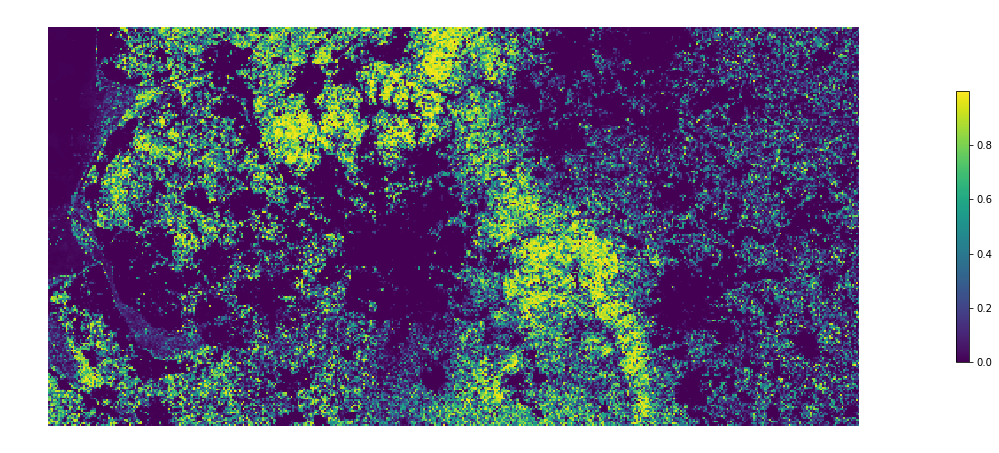

In [56]:
ax = pred.plot("wild_countryside", figsize=(20, 10), legend=True, legend_kwds={'shrink': 0.5})
ax.set_axis_off()
plt.savefig("figs/image_class_country.png", bbox_inches="tight")

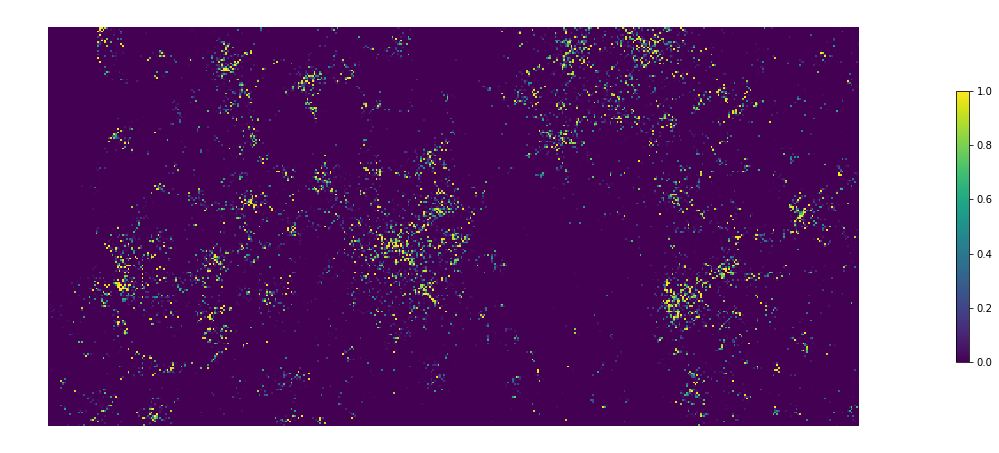

In [57]:
ax = pred.plot("urbanity", figsize=(20, 10), legend=True, legend_kwds={'shrink': 0.5})
ax.set_axis_off()
plt.savefig("figs/image_class_urban.png", bbox_inches="tight")

In [67]:
pred.to_parquet("../../urbangrammar_samba/spatial_signatures/chips/32_nw_pred.parquet")

/tmp/ipykernel_6631/2264496793.py:1: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  pred.to_parquet("../../urbangrammar_samba/spatial_signatures/chips/32_nw_pred.parquet")


In [64]:
props = geopandas.read_parquet('../../chips/32_nw/chip_proportions.pq')

<AxesSubplot:>

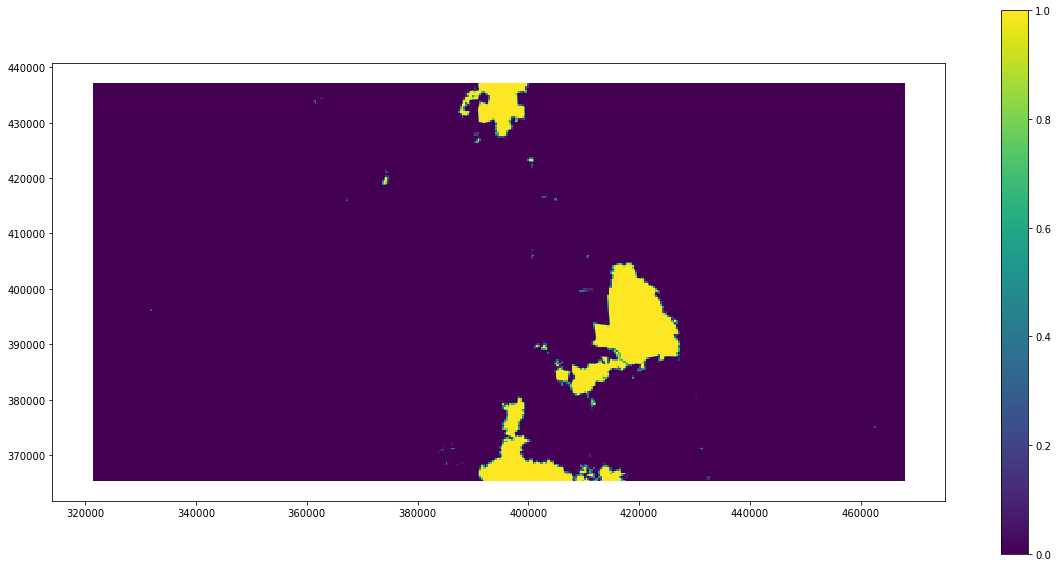

In [69]:
props.plot("signature_type_4_0", figsize=(20, 10), legend=True,)

## Multi output regression

In [58]:
geom = geopandas.read_parquet("/home/jovyan/work/chips/32_nw/chip_bounds/")
pred = numpy.load("../../chips/32_nw_pred_multiclass.npy")

In [60]:
key = {'accessible_suburbia': 0,
 'connected_residential_neighbourhoods': 1,
 'countryside_agriculture': 2,
 'dense_residential_neighbourhoods': 3,
 'dense_urban_neighbourhoods': 4,
 'disconnected_suburbia': 5,
 'gridded_residential_quarters': 6,
 'open_sprawl': 7,
 'urban_buffer': 8,
 'urbanity': 9,
 'warehouse_park_land': 10,
 'wild_countryside': 11}

pred = pandas.DataFrame(pred, columns=key.keys())

In [61]:
pred = geopandas.GeoDataFrame(pred, geometry=geom.geometry.values)

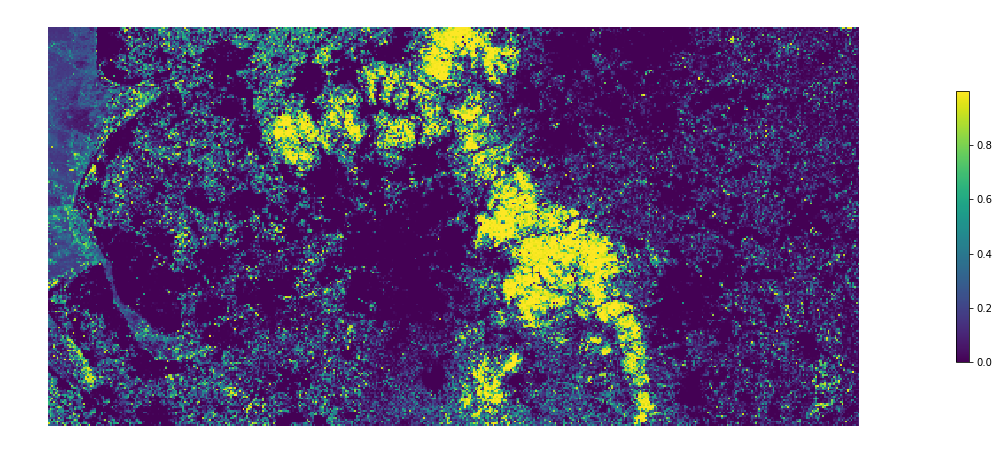

In [62]:
ax = pred.plot("wild_countryside", figsize=(20, 10), legend=True, legend_kwds={'shrink': 0.5})
ax.set_axis_off()
plt.savefig("figs/mor_country.png", bbox_inches="tight")

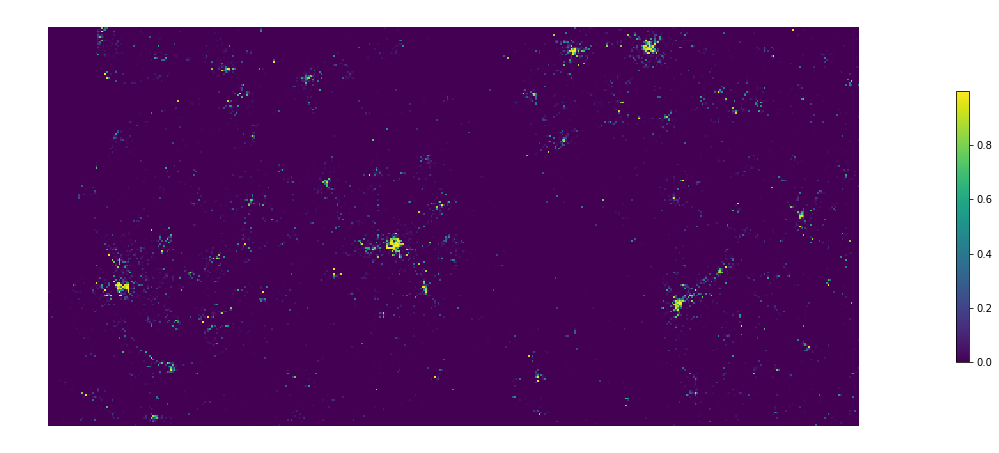

In [63]:
ax = pred.plot("urbanity", figsize=(20, 10), legend=True, legend_kwds={'shrink': 0.5})
ax.set_axis_off()
plt.savefig("figs/mor_urban.png", bbox_inches="tight")

<AxesSubplot:>

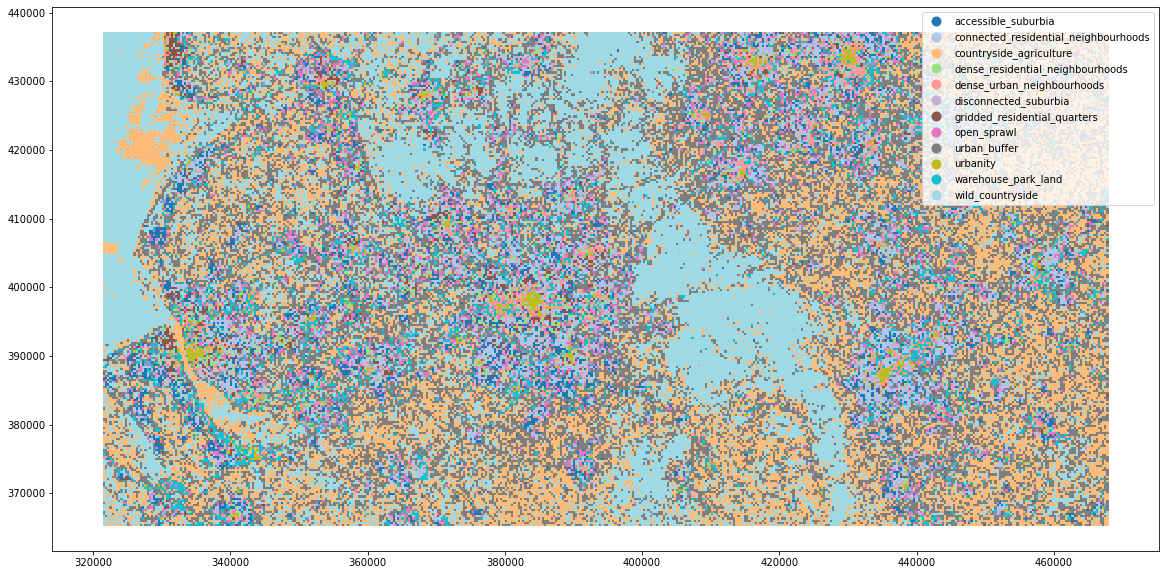

In [20]:
cats = pred.drop(columns="geometry").idxmax(axis=1)
pred.plot(cats, figsize=(20, 10), legend=True, cmap='tab20')

In [14]:
pred.to_parquet("../../urbangrammar_samba/spatial_signatures/chips/32_nw_pred_multiclass.parquet")

/tmp/ipykernel_12843/3647684065.py:1: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  pred.to_parquet("../../urbangrammar_samba/spatial_signatures/chips/32_nw_pred_multiclass.parquet")


## 64

In [5]:
specs = {
    'bb': box(321566, 365379, 468106, 437198),
    'chip_size': 64,
    'bands': [1, 2, 3], #RGB
    'mosaic_p': (
        '/home/jovyan/work/urbangrammar_samba/'
        'ghs_composite_s2/GHS-composite-S2.vrt'
    ),
    'folder': (
        '../../chips/64_nw/chips/'
    ),
}

In [6]:
r = rioxarray.open_rasterio(
    specs['mosaic_p'], chunks={'x': 1024, 'y': 1024}
)

### Get range of coordinates from the mosaic

In [7]:
sample = nw
start_x = sample[0]
start_y = sample[1]
end_x = sample[2]
end_y = sample[3]

In [8]:
x_coords = numpy.arange(start_x, end_x, specs["chip_size"] * 10)
y_coords = numpy.arange(start_y, end_y, specs["chip_size"] * 10)

In [9]:
x_bag = dask.bag.from_sequence(x_coords)
y_bag = dask.bag.from_sequence(y_coords)

In [10]:
product_bag = x_bag.product(y_bag)

In [11]:
ddf = product_bag.to_dataframe(meta={"x": float, "y":float})

In [12]:
ddf["geometry"] = dask_geopandas.points_from_xy(ddf, "x", "y", crs=27700)

In [13]:
gddf = dask_geopandas.from_dask_dataframe(ddf).set_crs(27700)

In [14]:
polygons = gddf.buffer(specs['chip_size'] * 10 / 2, cap_style=3)

In [15]:
gddf["geometry"] = polygons

In [ ]:
gddf.to_parquet("/home/jovyan/work/chips/64_nw/chip_bounds/", overwrite=True)

In [17]:
client.restart()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 16
Total threads: 16,Total memory: 125.54 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35885,Workers: 16
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: 11 minutes ago,Total memory: 125.54 GiB
Comm: tcp://127.0.0.1:34931,Total threads: 1
Dashboard: http://127.0.0.1:34219/status,Memory: 7.85 GiB
Nanny: tcp://127.0.0.1:46591,


In [18]:
df = geopandas.read_parquet("/home/jovyan/work/chips/64_nw/chip_bounds/")

In [19]:
centroid = df.centroid
df['X'] = centroid.x.astype(int)
df['Y'] = centroid.y.astype(int)
# Split chip_bbs
thr = numpy.linspace(0, df.shape[0], 17, dtype=int)
chunks = [
    (df.iloc[thr[i]:thr[i+1], :], specs) for i in range(len(thr)-1)
]

In [20]:
chips = bag_of_chips(df, specs, 16)

distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 55% CPU time recently (threshold: 10%)


In [21]:
numpy.save('../../chips/64_nw.npy', chips)

Inference in another notebook happens here

In [22]:
pred = numpy.load("../../chips/64_nw_pred_multiclass.npy")

In [23]:
key = {'accessible_suburbia': 0,
 'connected_residential_neighbourhoods': 1,
 'countryside_agriculture': 2,
 'dense_residential_neighbourhoods': 3,
 'dense_urban_neighbourhoods': 4,
 'disconnected_suburbia': 5,
 'gridded_residential_quarters': 6,
 'open_sprawl': 7,
 'urban_buffer': 8,
 'urbanity': 9,
 'warehouse_park_land': 10,
 'wild_countryside': 11}

pred = pandas.DataFrame(pred, columns=key.keys())

In [24]:
pred = geopandas.GeoDataFrame(pred, geometry=df.geometry.values)

<AxesSubplot:>

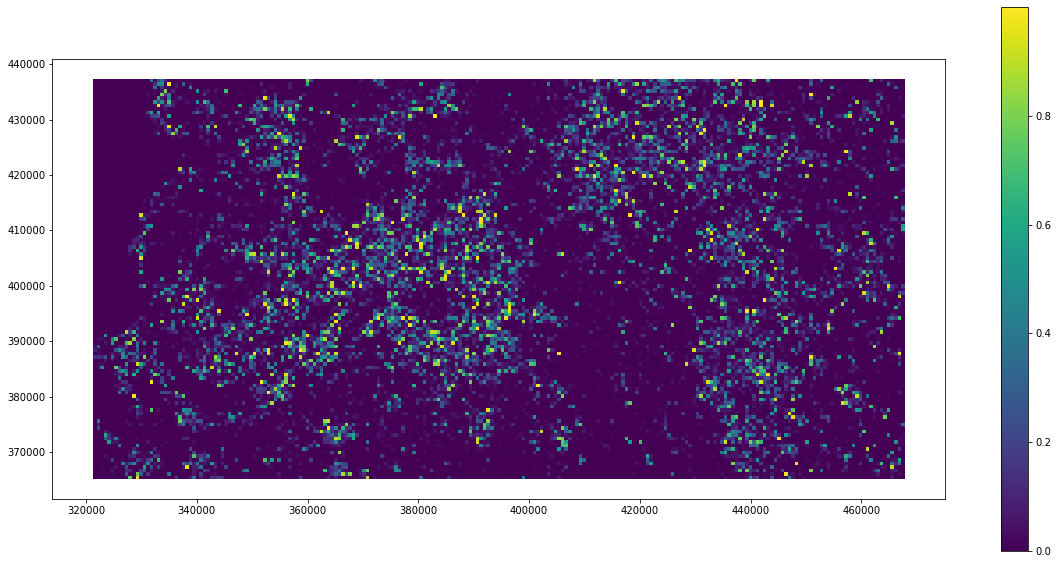

In [33]:
pred.plot("open_sprawl", figsize=(20, 10), legend=True,)

<AxesSubplot:>

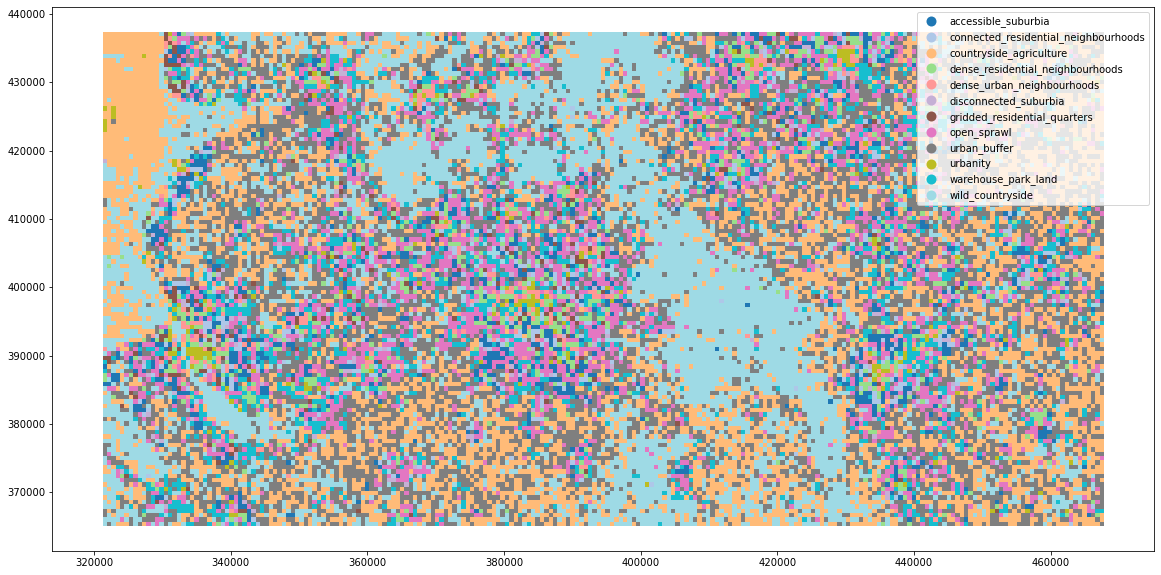

In [28]:
cats = pred.drop(columns="geometry").idxmax(axis=1)
pred.plot(cats, figsize=(20, 10), legend=True, cmap='tab20')

In [34]:
db = geopandas.read_parquet("../../urbangrammar_samba/spatial_signatures/chips/32_nw_pred.parquet")

In [35]:
from libpysal import weights

In [36]:
q = weights.Queen.from_dataframe(db)

In [38]:
pandas.Series(q.cardinalities).value_counts()

8    101688
5      1358
3         4
dtype: int64

In [71]:
props.drop(columns='geometry')[props.drop(columns='geometry').max(axis=1) == 1].idxmax(axis=1).value_counts()

signature_type_7_0    26792
signature_type_0_0    25758
signature_type_3_0     4896
signature_type_4_0     3154
signature_type_5_0     2144
signature_type_1_0     1589
signature_type_2_0      365
signature_type_6_0      279
signature_type_2_2      253
signature_type_2_1      232
signature_type_8_0       68
signature_type_9_0       14
signature_type_9_2       12
signature_type_9_4        1
dtype: int64